# Modeling - Census Income Prediction

This notebook performs:
- **Model Selection**: Choose which model to train (configured in `config/config.yaml`)
- Load preprocessed data (automatically selects raw or processed based on model)
- Hyperparameter tuning (Optuna for LightGBM, GridSearchCV for Random Forest)
- Model training with best hyperparameters
- Model evaluation and performance visualization

**Supported Models:**
- `lightgbm` - Uses Optuna for HPT, raw data (native categorical support)
- `random_forest` - Uses GridSearchCV for HPT, processed data

**To change the model**, edit `config/config.yaml` and set `modeling.model_type` to your desired model.


In [3]:
# Import necessary libraries
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path.cwd().parent))

import pandas as pd
import numpy as np
import yaml
import json
import joblib
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import train_test_split

# Optuna imports
from optuna.visualization import plot_optimization_history

# Import project modules
from src.modeling import (
    load_hyperparameter_config,
    optimize_lightgbm_hyperparameters,
    train_lightgbm_with_params,
    train_random_forest,
    evaluate_model_performance,
    plot_model_performance
)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Model Selection


In [4]:
print("=" * 80)
print("MODEL SELECTION")
print("=" * 80)

# Load main config to get model selection
main_config_path = "../config/config.yaml"
with open(main_config_path, 'r') as f:
    main_config = yaml.safe_load(f)

model_type = main_config['modeling']['model_type'].lower()
model_config_path = "../config/model_config.yaml"

print(f"\nSelected model: {model_type.upper()}")
print(f"Model config path: {model_config_path}")

# Check if model is enabled in model_config
model_config = load_hyperparameter_config(model_config_path)
if model_type not in model_config.get('models', {}):
    raise ValueError(f"Model '{model_type}' not found in {model_config_path}")

if not model_config['models'][model_type].get('enabled', True):
    raise ValueError(f"Model '{model_type}' is disabled in {model_config_path}")

print(f"Model '{model_type}' is enabled and ready to use")

# Determine which data version to use
# LightGBM can use raw (categorical) data, others need encoded
#if model_type == 'lightgbm':
#    data_version = "raw"  # Use raw version for native categorical support
#    print(f"\nUsing RAW data version (for native categorical feature support)")
#else:
#    data_version = "processed"  # Use encoded version for other models
#    print(f"\nUsing PROCESSED data version (with categorical encoding)")

data_version = "processed"  # Use encoded version for other models
print(f"\nUsing PROCESSED data version (with categorical encoding)")

print(f"\nModel selection complete!")


MODEL SELECTION

Selected model: LIGHTGBM
Model config path: ../config/model_config.yaml
Model 'lightgbm' is enabled and ready to use

Using PROCESSED data version (with categorical encoding)

Model selection complete!


## 2. Load Preprocessed Data

**Note**: We use the raw version (without categorical encoding) since LightGBM can handle categorical features natively. For cross-validation, train and validation are kept together in the same file.


In [5]:
# Load preprocessed data
# Data version will be determined by model selection (raw for LightGBM, processed for others)
# For now, we'll load both and select based on model_type in next cell

print("Loading preprocessed data...")
train_full_raw_path = "../data/processed/train_full_raw.csv"
train_full_processed_path = "../data/processed/train_full_processed.csv"
test_raw_path = "../data/processed/test_raw.csv"
test_processed_path = "../data/processed/test_processed.csv"

# Load both versions (will select which to use based on model)
train_full_raw_df = pd.read_csv(train_full_raw_path)
train_full_processed_df = pd.read_csv(train_full_processed_path)
test_raw_df = pd.read_csv(test_raw_path)
test_processed_df = pd.read_csv(test_processed_path)

print("Loaded both raw and processed versions")

# Select data based on selected model
# LightGBM uses raw (categorical), others use processed (encoded)

if data_version == "raw":
    train_full_df = train_full_raw_df.copy()
    test_df = test_raw_df.copy()
    print("Using RAW data version (for native categorical feature support)")
else:
    train_full_df = train_full_processed_df.copy()
    test_df = test_processed_df.copy()
    print("Using PROCESSED data version (with categorical encoding)")

# Separate features and target
target_col = 'income'

X_train_full = train_full_df.drop(columns=[target_col])
y_train_full = train_full_df[target_col]
X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]

# Split train_full into train and validation for hyperparameter tuning
# Note: For cross-validation, you can use train_full directly
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    random_state=42,
    stratify=y_train_full
)

print(f"\nData shapes:")
print(f"Training (from train_full): {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Validation (from train_full): {X_val.shape[0]} samples, {X_val.shape[1]} features")
print(f"Test: {X_test.shape[0]} samples, {X_test.shape[1]} features")
print(f"Train+Val combined (for CV): {X_train_full.shape[0]} samples, {X_train_full.shape[1]} features")

print(f"\nTarget distribution:")
print(f"Training: {y_train.value_counts().to_dict()}")
print(f"Validation: {y_val.value_counts().to_dict()}")
print(f"Test: {y_test.value_counts().to_dict()}")
print(f"Train+Val combined: {y_train_full.value_counts().to_dict()}")



Loading preprocessed data...
Loaded both raw and processed versions
Using PROCESSED data version (with categorical encoding)

Data shapes:
Training (from train_full): 122316 samples, 53 features
Validation (from train_full): 30580 samples, 53 features
Test: 78864 samples, 53 features
Train+Val combined (for CV): 152896 samples, 53 features

Target distribution:
Training: {0: 112422, 1: 9894}
Validation: {0: 28107, 1: 2473}
Test: {0: 72678, 1: 6186}
Train+Val combined: {0: 140529, 1: 12367}


## 3. Hyperparameter Tuning


In [7]:
print("=" * 80)
print(f"HYPERPARAMETER TUNING - {model_type.upper()}")
print("=" * 80)

# Load hyperparameter configuration
model_config_path = "../config/model_config.yaml"
config = load_hyperparameter_config(model_config_path)

if model_type == 'lightgbm':
    # Use Optuna for LightGBM
    print(f"\nUsing Optuna for hyperparameter optimization")
    print(f"Parameters to optimize: {list(config['models']['lightgbm']['params'].keys())}")
    
    # Get HPT settings from main config
    n_trials_random = main_config['modeling']['hpt']['n_trials_random']
    n_trials_tpe = main_config['modeling']['hpt']['n_trials_tpe']
    
    print(f"\nOptimization strategy:")
    print(f"  - Random search trials: {n_trials_random}")
    print(f"  - TPE optimization trials: {n_trials_tpe}")
    print(f"  - Total trials: {n_trials_random + n_trials_tpe}")
    print(f"  - Optimizing for: ROC-AUC (handles class imbalance well)")
    
    study, best_params = optimize_lightgbm_hyperparameters(
        X_train,
        y_train,
        X_val,
        y_val,
        config_path=model_config_path,
        n_trials_random=n_trials_random,
        n_trials_tpe=n_trials_tpe,
        random_state=42
    )
    
    print(f"\n{'='*80}")
    print("OPTIMIZATION COMPLETE")
    print(f"{'='*80}")
    print(f"\nBest validation AUC: {study.best_value:.4f}")
    print(f"\nBest hyperparameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    
    # Store study for visualization
    optuna_study = study
    
else:
    # Use GridSearchCV/RandomizedSearchCV for other models
    print(f"\nBest CV score: {best_score:.4f}")
    print(f"\nBest hyperparameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    
    # For non-Optuna models, store the trained model
    best_model_hpt = model
    optuna_study = None

print(f"\nHyperparameter tuning complete!")

[I 2025-11-07 14:43:40,051] A new study created in memory with name: lightgbm_optimization


HYPERPARAMETER TUNING - LIGHTGBM

Using Optuna for hyperparameter optimization
Parameters to optimize: ['n_estimators', 'max_depth', 'learning_rate', 'num_leaves', 'feature_fraction', 'bagging_fraction', 'bagging_freq', 'min_child_samples', 'min_data_in_leaf', 'reg_alpha', 'reg_lambda', 'min_gain_to_split']

Optimization strategy:
  - Random search trials: 50
  - TPE optimization trials: 20
  - Total trials: 70
  - Optimizing for: ROC-AUC (handles class imbalance well)
Running 50 random search trials...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-07 14:43:44,666] Trial 0 finished with value: 0.9341609056178665 and parameters: {'n_estimators': 437, 'max_depth': 8, 'learning_rate': 0.06504856968981275, 'num_leaves': 44, 'feature_fraction': 0.46240745617697465, 'bagging_fraction': 0.46239780813448106, 'bagging_freq': 1, 'min_child_samples': 176, 'min_data_in_leaf': 128, 'reg_alpha': 1.084636916089126, 'reg_lambda': 0.00013101180060230306, 'min_gain_to_split': 0.9699098521619943}. Best is trial 0 with value: 0.9341609056178665.
[I 2025-11-07 14:43:55,499] Trial 1 finished with value: 0.9191370620253079 and parameters: {'n_estimators': 850, 'max_depth': 4, 'learning_rate': 0.002820996133514492, 'num_leaves': 23, 'feature_fraction': 0.5216968971838152, 'bagging_fraction': 0.6099025726528952, 'bagging_freq': 4, 'min_child_samples': 72, 'min_data_in_leaf': 130, 'reg_alpha': 0.0006236936575328396, 'reg_lambda': 0.00462299675855266, 'min_gain_to_split': 0.3663618432936917}. Best is trial 0 with value: 0.9341609056178665.
[I 20

  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-11-07 14:52:13,032] Trial 50 finished with value: 0.934751666955336 and parameters: {'n_estimators': 744, 'max_depth': 5, 'learning_rate': 0.03055827071614155, 'num_leaves': 54, 'feature_fraction': 0.5326470057790307, 'bagging_fraction': 0.5022706831989248, 'bagging_freq': 2, 'min_child_samples': 89, 'min_data_in_leaf': 106, 'reg_alpha': 3.2876502776543477, 'reg_lambda': 0.0001326561386204664, 'min_gain_to_split': 0.4431184018156168}. Best is trial 22 with value: 0.9359406491377018.
[I 2025-11-07 14:52:41,300] Trial 51 finished with value: 0.9346081811360034 and parameters: {'n_estimators': 516, 'max_depth': 5, 'learning_rate': 0.03816535046123269, 'num_leaves': 54, 'feature_fraction': 0.5257158420093662, 'bagging_fraction': 0.5145062719298694, 'bagging_freq': 2, 'min_child_samples': 92, 'min_data_in_leaf': 101, 'reg_alpha': 21.99874082567242, 'reg_lambda': 0.00014350649276880344, 'min_gain_to_split': 0.4418564930341645}. Best is trial 22 with value: 0.9359406491377018.
[I 2025

## 4. Optuna Visualization (LightGBM only)


In [8]:
print("=" * 80)
print("OPTUNA OPTIMIZATION VISUALIZATION")
print("=" * 80)

# Plot optimization history
fig = plot_optimization_history(study)
fig.update_layout(title="Optimization History - Validation AUC", width=800, height=500)
fig.show()

# Try to save figure (requires kaleido package for plotly image export)
try:
    fig.write_image("../results/figures/optuna_optimization_history.png")
    print("\nOptimization history plot saved to: ../results/figures/optuna_optimization_history.png")
except Exception as e:
    print(f"\nNote: Could not save plotly figure as image: {e}")
    print("Install kaleido package for image export: pip install kaleido")


OPTUNA OPTIMIZATION VISUALIZATION



Note: Could not save plotly figure as image: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

Install kaleido package for image export: pip install kaleido


## 3. Optuna Visualization


## 5. Train Best Model


In [9]:
print("=" * 80)
print("TRAIN BEST MODEL")
print("=" * 80)

if model_type == 'lightgbm':
    # Calculate class weights for imbalance handling
    from sklearn.utils.class_weight import compute_class_weight
    classes = np.unique(y_train)
    class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weight_dict = dict(zip(classes, class_weights))
    
    print(f"\nClass weights: {class_weight_dict}")
    
    # Train model with best hyperparameters
    best_model = train_lightgbm_with_params(
        X_train,
        y_train,
        X_val,
        y_val,
        params=best_params,
        class_weight=class_weight_dict
    )
    
    print(f"\nModel trained successfully!")
    print(f"Best iteration: {best_model.best_iteration}")
    print(f"Best validation score: {best_model.best_score['val']['auc']:.4f}")
    
elif model_type == 'random_forest':
    # For sklearn models, best_model was already trained during HPT
    if 'best_model_hpt' in locals():
        best_model = best_model_hpt
        print(f"\nUsing model trained during hyperparameter tuning")
        print(f"Best CV score: {results['best_score']:.4f}")
    else:
        # Retrain with best params if needed
        print(f"\nRetraining {model_type} with best hyperparameters...")
        if model_type == 'xgboost':
            best_model, _ = train_xgboost(
                X_train, y_train,
                params=best_params,
                cv=5,
                scoring='roc_auc'
            )
        elif model_type == 'random_forest':
            best_model, _ = train_random_forest(
                X_train, y_train,
                params=best_params,
                cv=5,
                scoring='roc_auc'
            )
        elif model_type == 'logistic_regression':
            best_model, _ = train_logistic_regression(
                X_train, y_train,
                params=best_params,
                cv=5,
                scoring='roc_auc'
            )
        print(f"\nModel retrained successfully!")
else:
    raise ValueError(f"Unsupported model type: {model_type}")

print(f"\nModel training complete!")



TRAIN BEST MODEL

Class weights: {np.int64(0): np.float64(0.5440038426642472), np.int64(1): np.float64(6.181322013341419)}

Model trained successfully!
Best iteration: 386
Best validation score: 0.9362

Model training complete!


## 6. Evaluate Model Performance


In [10]:
print("=" * 80)
print("EVALUATE MODEL PERFORMANCE")
print("=" * 80)

# Evaluate on all datasets
train_metrics = evaluate_model_performance(best_model, X_train, y_train, "Train")
val_metrics = evaluate_model_performance(best_model, X_val, y_val, "Validation")
test_metrics = evaluate_model_performance(best_model, X_test, y_test, "Test")

# Display metrics
print("\nPerformance Metrics:")
print("\nTraining Set:")
print(f"  Precision: {train_metrics['precision']:.4f}")
print(f"  Recall: {train_metrics['recall']:.4f}")
print(f"  F1-Score: {train_metrics['f1']:.4f}")
print(f"  ROC-AUC: {train_metrics['roc_auc']:.4f}")

print("\nValidation Set:")
print(f"  Precision: {val_metrics['precision']:.4f}")
print(f"  Recall: {val_metrics['recall']:.4f}")
print(f"  F1-Score: {val_metrics['f1']:.4f}")
print(f"  ROC-AUC: {val_metrics['roc_auc']:.4f}")

print("\nTest Set:")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall: {test_metrics['recall']:.4f}")
print(f"  F1-Score: {test_metrics['f1']:.4f}")
print(f"  ROC-AUC: {test_metrics['roc_auc']:.4f}")

# Display confusion matrices
print("\nConfusion Matrices:")
print("\nTraining Set:")
print(train_metrics['confusion_matrix'])
print("\nValidation Set:")
print(val_metrics['confusion_matrix'])
print("\nTest Set:")
print(test_metrics['confusion_matrix'])


EVALUATE MODEL PERFORMANCE

Performance Metrics:

Training Set:
  Precision: 0.3601
  Recall: 0.8945
  F1-Score: 0.5135
  ROC-AUC: 0.9510

Validation Set:
  Precision: 0.3508
  Recall: 0.8645
  F1-Score: 0.4991
  ROC-AUC: 0.9362

Test Set:
  Precision: 0.3503
  Recall: 0.8676
  F1-Score: 0.4991
  ROC-AUC: 0.9412

Confusion Matrices:

Training Set:
[[96698 15724]
 [ 1044  8850]]

Validation Set:
[[24151  3956]
 [  335  2138]]

Test Set:
[[62725  9953]
 [  819  5367]]


## 7. Visualize Model Performance


VISUALIZE MODEL PERFORMANCE


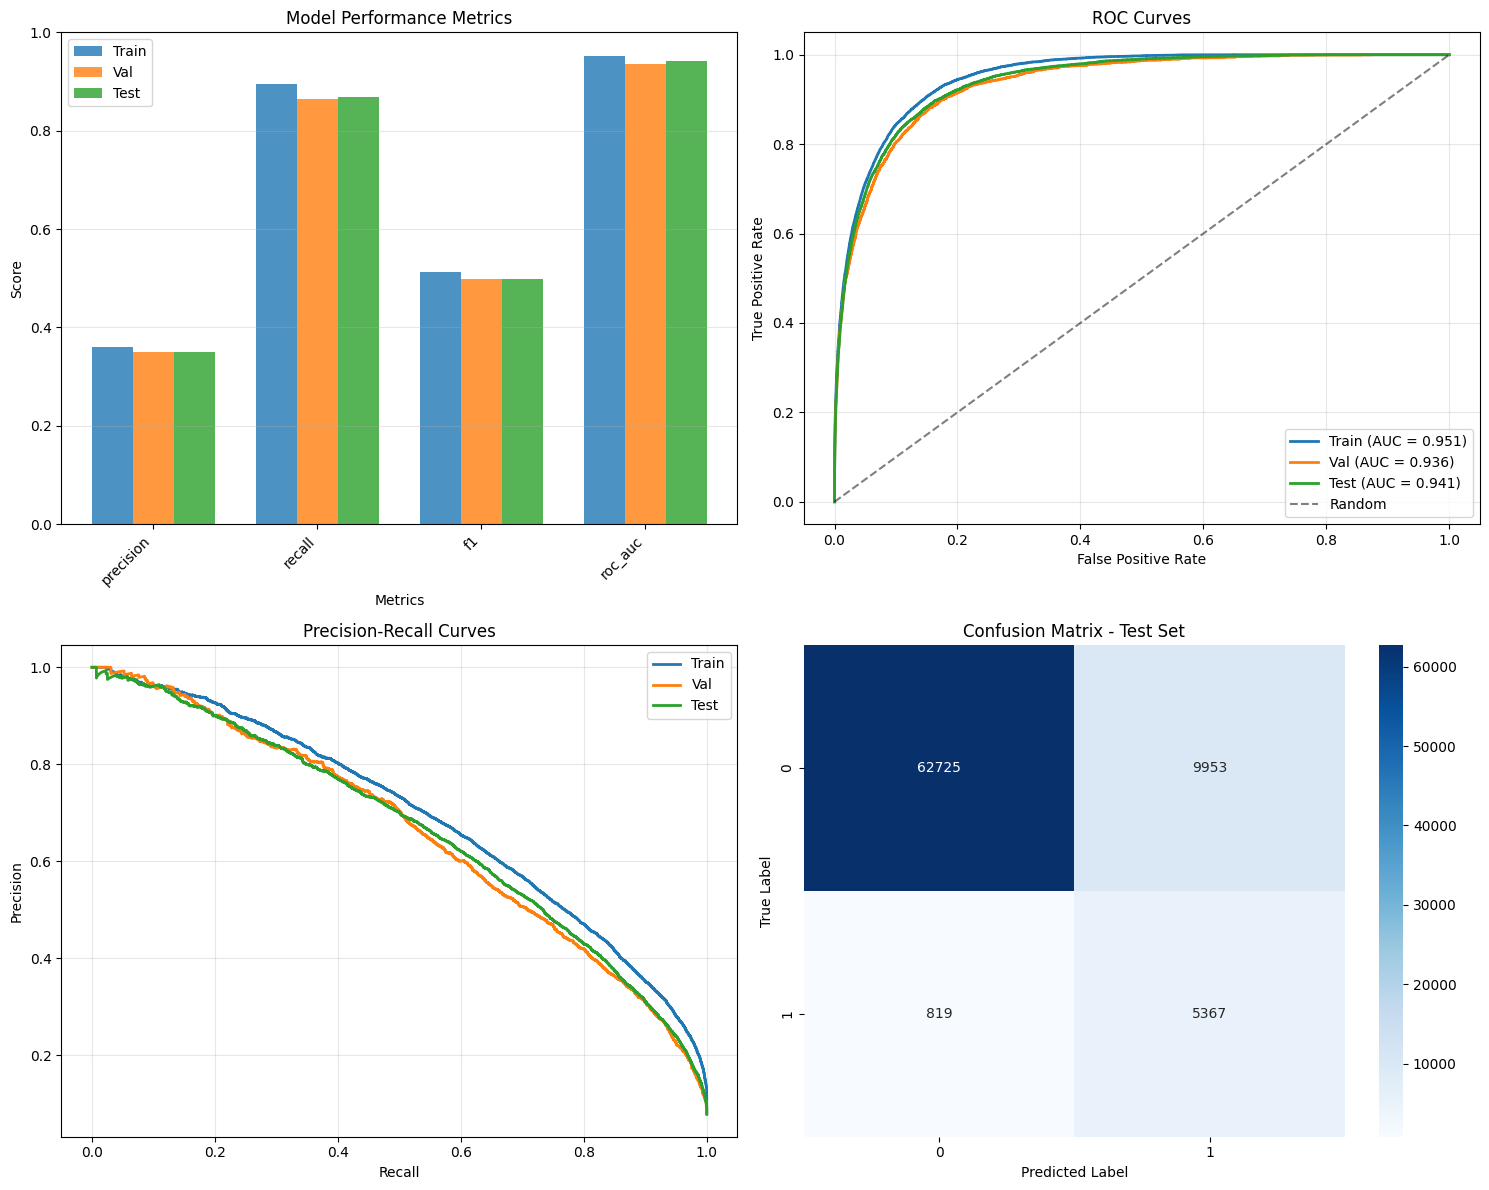


Performance plots saved to: ../results/figures/model_performance.png


In [11]:
print("=" * 80)
print("VISUALIZE MODEL PERFORMANCE")
print("=" * 80)

# Plot comprehensive performance visualization
plot_model_performance(
    train_metrics,
    val_metrics,
    test_metrics,
    save_path="../results/figures/model_performance.png"
)

print("\nPerformance plots saved to: ../results/figures/model_performance.png")


## 8. Save Model


In [12]:
print("=" * 80)
print("SAVE MODEL")
print("=" * 80)

# Create models directory
model_dir = Path("../models")
model_dir.mkdir(parents=True, exist_ok=True)

# Save model based on type
if model_type == 'lightgbm':
    model_path = model_dir / f"{model_type}_best_model.txt"
    best_model.save_model(str(model_path))
else:
    import joblib
    model_path = model_dir / f"{model_type}_best_model.pkl"
    joblib.dump(best_model, model_path)

# Save best parameters
import json
params_path = model_dir / f"{model_type}_best_params.json"
with open(params_path, 'w') as f:
    json.dump(best_params, f, indent=2)

print(f"\nModel saved to: {model_path}")
print(f"Best parameters saved to: {params_path}")
print("\nModeling complete!")



SAVE MODEL

Model saved to: ../models/lightgbm_best_model.txt
Best parameters saved to: ../models/lightgbm_best_params.json

Modeling complete!
